In [96]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
from sklearn.preprocessing import MinMaxScaler
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [97]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/Bangkit/student_spending modif.csv'
data = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the dataset and its basic info to understand its structure
print(data.head())
print(data.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Unnamed: 0        date  monthly_income  financial_aid  tuition  housing  \
0           0  01/01/2021             958            270     5939      709   
1           1  02/01/2021            1006            875     4908      557   
2           2  03/01/2021             734            928     3051      666   
3           3  04/01/2021             617            265     4935      652   
4           4  05/01/2021             810            522     3887      825   

   food  transportation  books_supplies  entertainment  personal_care  \
0   296             123             188             41             78   
1   365              85             252             74             92   
2   220             137              99            130             23   
3   289             114             223             99             30   
4   372             168             1

Unnamed: 0                  0
date                        0
monthly_income              0
financial_aid               0
tuition                     0
housing                     0
food                        0
transportation              0
books_supplies              0
entertainment               0
personal_care               0
technology                  0
health_wellness             0
miscellaneous               0
Total_Expense               0
preferred_payment_method    0
dtype: int64
count    1000.000000
mean     6315.478000
std       885.890762
min      4453.000000
25%      5569.500000
50%      6289.000000
75%      7047.250000
max      8266.000000
Name: Total_Expense, dtype: float64


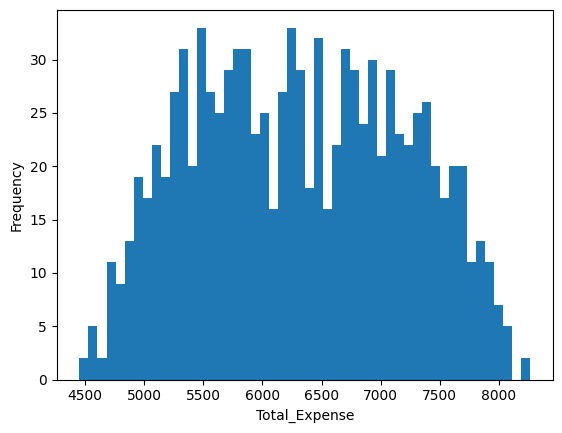

In [98]:
# Check for any NaN values
print(data.isna().sum())

# Check the range of the Total_Expense values
print(data['Total_Expense'].describe())

# Plot the Total_Expense to see its distribution
plt.hist(data['Total_Expense'], bins=50)
plt.xlabel('Total_Expense')
plt.ylabel('Frequency')
plt.show()


## Parsing and Normalize the raw data


In [100]:
def parse_data_from_file(filename):
    data = pd.read_csv(filename, delimiter=';')
    # Assuming 'date' is of type string and 'Total_Expense' is numeric
    data['Total_Expense'] = pd.to_numeric(data['Total_Expense'], errors='coerce')
    data = data.dropna(subset=['Total_Expense'])  # Drop rows where 'Total_Expense' is NaN
    date = data['date'].tolist()
    Total_Expense = data['Total_Expense'].tolist()
    return date, Total_Expense

In [101]:
# scaler = MinMaxScaler()
# data['Total_Expense'] = scaler.fit_transform(data[['Total_Expense']])

# # Verify the normalization
# print(data['Total_Expense'].describe())

# # Update the parse_data_from_file function to include normalization
# def parse_data_from_file(filename):
#     data = pd.read_csv(filename, delimiter=';')
#     data['Total_Expense'] = pd.to_numeric(data['Total_Expense'], errors='coerce')
#     data = data.dropna(subset=['Total_Expense'])  # Drop rows where 'Total_Expense' is NaN

#     # Normalize the Total_Expense column
#     scaler = MinMaxScaler()
#     data['Total_Expense'] = scaler.fit_transform(data[['Total_Expense']])

#     date = data['date'].tolist()
#     Total_Expense = data['Total_Expense'].tolist()
#     return date, Total_Expense

# Normalize data
def normalize_data(Total_Expense):
    scaler = MinMaxScaler()
    Total_Expense = np.array(Total_Expense).reshape(-1, 1)
    Total_Expense = scaler.fit_transform(Total_Expense).flatten()
    return Total_Expense, scaler


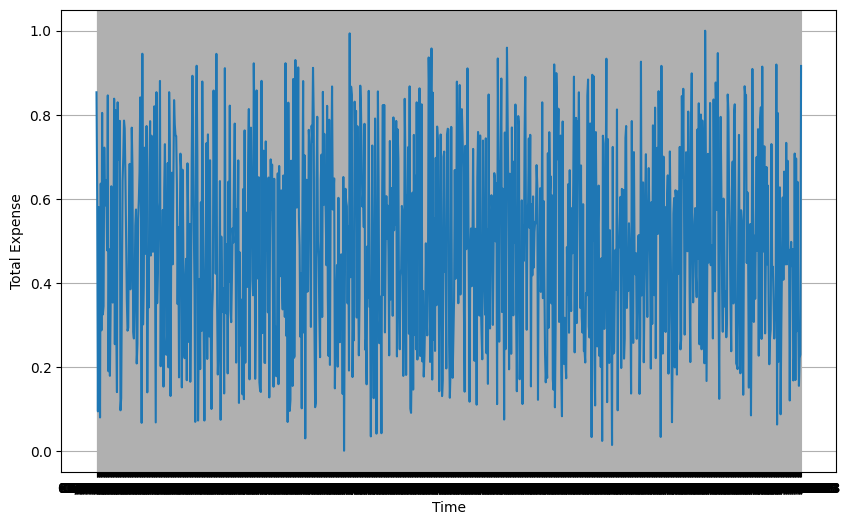

In [103]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    file_path = '/content/drive/MyDrive/Bangkit/student_spending modif.csv'
    date, Total_Expense = parse_data_from_file(file_path)
    Total_Expense, scaler = normalize_data(Total_Expense)
    TIME = np.array(date)
    SERIES = np.array(Total_Expense)
    SPLIT_TIME = 750  # Adjusted for 1000 rows
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    scaler = scaler

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Total Expense')
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [104]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [105]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train)

## Defining the model architecture

In [106]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    return model

In [107]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()
for X, y in train_set.take(1):
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    y_pred_shape = y_pred.squeeze().shape
    assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

In [108]:
# def adjust_learning_rate(dataset):

#     model = create_uncompiled_model()

#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

#     ### START CODE HERE

#     # Select your optimizer
#     optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-8)

#     # Compile the model passing in the appropriate loss
#     model.compile(loss=tf.keras.losses.Huber(),
#                   optimizer=optimizer,
#                   metrics=["mae"])

#     ### END CODE HERE

#     history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

#     return history

def adjust_learning_rate(dataset):
    model = create_uncompiled_model()
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    return history

In [109]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
22/22 [==============================] - 6s 52ms/step - loss: 7.6548 - mae: 8.1548 - lr: 1.0000e-08
Epoch 2/100
22/22 [==============================] - 1s 49ms/step - loss: 7.6515 - mae: 8.1515 - lr: 1.1220e-08
Epoch 3/100
22/22 [==============================] - 1s 62ms/step - loss: 7.6478 - mae: 8.1478 - lr: 1.2589e-08
Epoch 4/100
22/22 [==============================] - 2s 81ms/step - loss: 7.6439 - mae: 8.1439 - lr: 1.4125e-08
Epoch 5/100
22/22 [==============================] - 1s 53ms/step - loss: 7.6395 - mae: 8.1395 - lr: 1.5849e-08
Epoch 6/100
22/22 [==============================] - 1s 49ms/step - loss: 7.6347 - mae: 8.1347 - lr: 1.7783e-08
Epoch 7/100
22/22 [==============================] - 1s 50ms/step - loss: 7.6294 - mae: 8.1294 - lr: 1.9953e-08
Epoch 8/100
22/22 [==============================] - 1s 50ms/step - loss: 7.6231 - mae: 8.1231 - lr: 2.2387e-08
Epoch 9/100
22/22 [==============================] - 1s 49ms/step - loss: 7.6159 - mae: 8.1159 - lr: 2.5

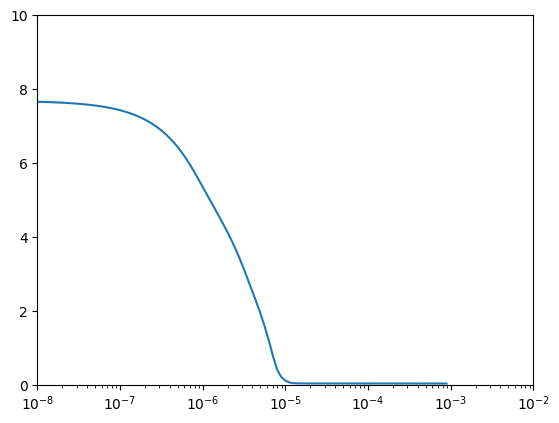

In [110]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 10])
plt.show()

## Compiling the model


In [111]:
# def create_model():


#     model = create_uncompiled_model()

#     ### START CODE HERE

#     model.compile(loss=tf.keras.losses.Huber(),
#                   optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
#                   metrics=["mae"])


#     ### END CODE HERE

#     return model

def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["mae"])
    return model

In [112]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
22/22 [==============================] - 7s 83ms/step - loss: 1.3361 - mae: 1.7767
Epoch 2/50
22/22 [==============================] - 1s 48ms/step - loss: 0.2070 - mae: 0.5258
Epoch 3/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0942 - mae: 0.3522
Epoch 4/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0536 - mae: 0.2647
Epoch 5/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0447 - mae: 0.2437
Epoch 6/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0550 - mae: 0.2684
Epoch 7/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0425 - mae: 0.2395
Epoch 8/50
22/22 [==============================] - 2s 78ms/step - loss: 0.0383 - mae: 0.2263
Epoch 9/50
22/22 [==============================] - 2s 77ms/step - loss: 0.0372 - mae: 0.2232
Epoch 10/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0369 - mae: 0.2214
Epoch 11/50
22/22 [==============================] - 1s 48m

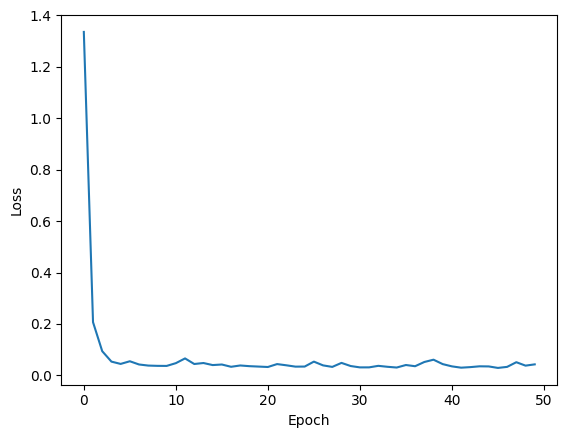

In [113]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluating the forecast

In [114]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

## Faster model forecasts

In [115]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Compute the actual forecast:

30/30 [==============================] - 1s 17ms/step


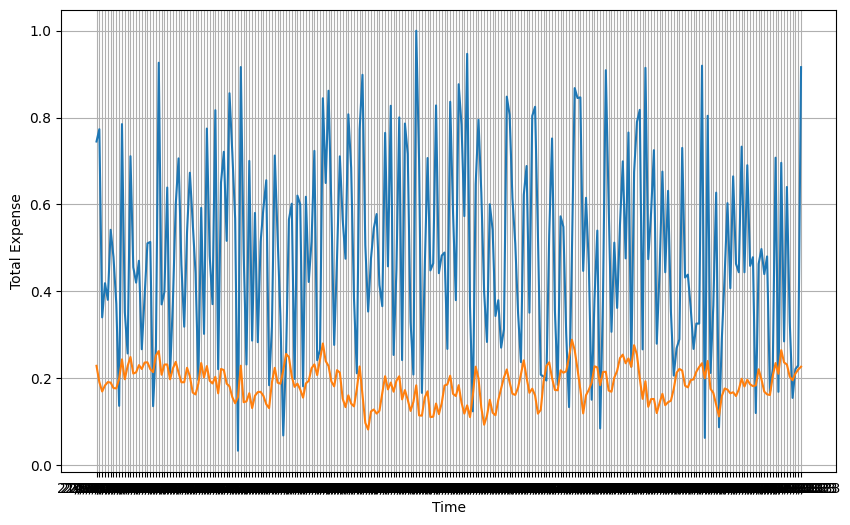

In [116]:
# # Compute the forecast for all the series
# rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# # Slice the forecast to get only the predictions for the validation set
# rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, series_valid)
# plot_series(time_valid, rnn_forecast)

rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [117]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.14, mae: 0.32 for forecast


In [123]:
# Forecasting the next day
def forecast_next_day(model, series, window_size, scaler):
    # Get the last 'window_size' data points
    last_window = series[-window_size:]

    # Reshape to match the model input
    last_window = np.expand_dims(last_window, axis=0)

    # Predict the next value
    next_prediction = model.predict(last_window)

    # Inverse transform the prediction to get the original scale
    next_prediction = scaler.inverse_transform(next_prediction.reshape(-1, 1)).flatten()

    return next_prediction

In [124]:
next_day_prediction = forecast_next_day(model, G.SERIES, G.WINDOW_SIZE, G.scaler)
print(f"Forecasted Total Expense for the next day: {next_day_prediction[0]:.2f}")

1/1 [==============================] - 0s 28ms/step
Forecasted Total Expense for the next day: 5216.83


In [125]:
# Forecasting for multiple days, weeks, or months
def multi_step_forecast(model, series, window_size, scaler, steps):
    predictions = []
    current_series = series.copy()

    for _ in range(steps):
        next_prediction = forecast_next_day(model, current_series, window_size, scaler)
        predictions.append(next_prediction[0])
        current_series = np.append(current_series, next_prediction)  # Append the prediction to the series

    return predictions

In [129]:
# Number of steps to forecast (e.g., next 30 days)
steps = 7
multi_step_predictions = multi_step_forecast(model, G.SERIES, G.WINDOW_SIZE, G.scaler, steps)

1/1 [==============================] - 0s 25ms/step


In [130]:
# # Plot the multi-step forecast
# future_dates = range(len(G.TIME), len(G.TIME) + steps)
# plt.figure(figsize=(10, 6))
# plot_series(G.TIME, G.SERIES)
# plot_series(future_dates, multi_step_predictions)
# plt.show()

In [131]:
# Print the multi-step forecast results
print("Multi-step forecast for the next 30 days:")
for i, prediction in enumerate(multi_step_predictions, 1):
    print(f"Day {i}: {prediction:.2f}")

Multi-step forecast for the next 30 days:
Day 1: 5216.83
Day 2: -4042.32
Day 3: -30392.83
Day 4: -28160.49
Day 5: -25186.56
Day 6: 16753.47
Day 7: 42230.70


In [120]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/fingerprint.pb
saved_model/my_model/keras_metadata.pb
saved_model/my_model/assets/
